In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cross_validation import train_test_split

%matplotlib inline

c:\python\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def scatter_plot(data, label, title, w=[]):
    cat1_x, cat1_y = [], []
    cat2_x, cat2_y = [], []
    
    for i, feature in enumerate(data):
        if label[i] == -1:
            cat1_x.append(feature[0])
            cat1_y.append(feature[1])
        else:
            cat2_x.append(feature[0])
            cat2_y.append(feature[1])
    
    #plt.scatter(cat0_x, cat0_y, c='r')
    plt.scatter(cat1_x, cat1_y, c='r', marker='D', label='class 0')
    plt.scatter(cat2_x, cat2_y, c='b', marker='^', label='class 1 and 2')
    if w != []:
        line_x = np.linspace(4, 8, 100)
        line_y = -(w[0] * line_x + w[2]) / w[1]
        plt.plot(line_x, line_y, 'k', label='decision boundary')
    plt.legend()
    plt.grid()
    plt.title(title)

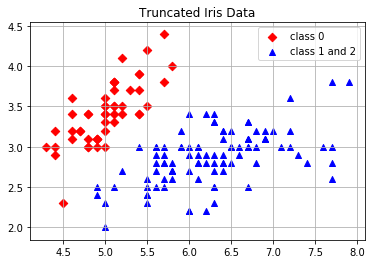

In [60]:
# Load iris dataset for use
# The class '1' and '2' are non-linearly separable classes
iris = datasets.load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1
# convert all labels into +1 or -1
y = y * 2 - 1
scatter_plot(X, y, 'Truncated Iris Data')

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [62]:
class my_SVM(object):
    
    def __init__(self, max_iter=100, kernel='linear'):
        self.max_iter = max_iter
        self._kernel = kernel
    
    def init_args(self, features, labels):
        self.X = features
        self.y = labels
        self.num_samples = features.shape[0]
        self.num_dims = features.shape[1]
        self.b = 0.0
        
        # Paramters used in SMO
        self.alpha = np.ones(self.num_samples)
        self.E = [self._E(i) for i in range(self.num_samples)]
        self.C = 1.0
        
    def _E(self, i):
        return self._g(i) - self.y[i]
    
    def _g(self, i):
        r = self.b
        for j in range(self.num_samples):
            r += self.alpha[j] * self.y[j] * self.kernel_cal(self.X[i], self.X[j])
        return r
    
    def kernel_cal(self, x1, x2):
        if self._kernel == 'linear':
            return np.dot(x1, x2)
        elif self._kernel == 'poly':
            return (np.dot(x1, x2) + 1) ** 2
        else:
            raise NotImplementedError("This kind of kernel is not support yet!")
    
    def _KKT(self, i):
        y_g = self._g(i) * self.y[i]
        if self.alpha[i] == 0:
            return y_g >= 1
        elif self.alpha[i] >= self.C:
            return y_g <= 1
        else:
            return y_g <= 1
        
    
    def _select_alpha(self):
        index_list, non_satisfy = [], []
        # indeces of alpha_i that satisfy the constrain
        for i in range(self.num_samples):
            if 0 < self.alpha[i] < self.C:
                index_list.append(i)
            else:
                non_satisfy.append(i)
        index_list.extend(non_satisfy)
        for i in index_list:
            if self._KKT(i):
                continue
            E1 = self.E[i]
            if E1 >= 0:
                j = min(range(self.num_samples), key=lambda x: self.E[x])
            else:
                j = max(range(self.num_samples), key=lambda x: self.E[x])
            return i, j
    
    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha
    
    def fit(self, features, labels):
        ''' Method to fit model with given data '''
        
        # initialize arguments of model
        self.init_args(features, labels)
        
        # training iteration, procedures of SMO algorithm
        for t in range(self.max_iter):
            i1, i2 = self._select_alpha()
            
            # define boundary of alpha_2
            if self.y[i1] == self.y[i2]:
                L = max(0, self.alpha[i2] + self.alpha[i1] - self.C)
                H = min(self.C, self.alpha[i2] + self.alpha[i1])
            else:
                L = max(0, self.alpha[i2] - self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])
            
            # calculate error refers to ground truth
            E1 = self._E(i1)
            E2 = self._E(i2)
            
            # eta = K_11 + K_22 - 2*K_12
            eta = self.kernel_cal(X[i1], X[i1]) + self.kernel_cal(X[i2], X[i2]) - 2 * self.kernel_cal(X[i1], X[i2])
            if eta <= 0:
                continue
            
            # calculate alpha_2
            alpha2_new_unc = self.alpha[i2] + self.y[i2] * (E1 - E1) / eta
            alpha2_new = self._compare(alpha2_new_unc, L, H)
            
            # calculate alpha_1
            alpha1_new = self.alpha[i1] + self.y[i1]*self.y[i2]*(self.alpha[i2] - alpha2_new)
            
            # calculate b
            b1_new = - E1 - self.y[i1] * self.kernel_cal(self.X[i1], self.X[i1])* (alpha1_new - self.alpha[i1]) \
            - self.y[i2] * self.kernel_cal(self.X[i2], self.X[i1])* (alpha2_new - self.alpha[i2]) + self.b
            
            b2_new = - E2 - self.y[i1] * self.kernel_cal(self.X[i1], self.X[i2])* (alpha1_new - self.alpha[i1]) \
            - self.y[i2] * self.kernel_cal(self.X[i2], self.X[i2])* (alpha2_new - self.alpha[i2]) + self.b
            
            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                b_new = (b1_new + b2_new) / 2
            
            # update parameters
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            # re-calculate (update) error
            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)
            print('Traning: {} / {} iteration'.format(t+1, self.max_iter), end='\r')
        print('\nTraining Done !')
        return
    
    def _predict_one(self, data):
        r = self.b
        for i in range(self.num_samples):
            r += self.alpha[i] * self.y[i] * self.kernel_cal(data, self.X[i])
        return 1 if r > 0 else -1
    
    def predict(self, test_X):
        res = []
        for sample in test_X:
            tmp = self._predict_one(sample)
            res.append(tmp)
        return res

In [63]:
svm = my_SVM(max_iter=200)
svm.fit(X_train, y_train)

Traning: 200 / 200 iteration
Training Done !


In [64]:
preds = svm.predict(X_test)
print('Accuracy: {}'.format((preds == y_test).mean()))

Accuracy: 0.7368421052631579
